## E-Commerce Customer Segmentation Project

### Problem Statement
This project aims to diversify and optimize marketing strategies and ultimately increase sales through customer segmentation. Using __transaction data from a UK-based online retail business between 2010 and 2011__, the analysis transforms order-level data into a customer-centric dataset and applies __classical RFM analysis__ alongside __K-means clustering__ to segment customers into distinct and behaviorally coherent groups. Based on these segments, the project seeks to provide data-driven insights and strategic recommendations for differentiated marketing approaches tailored to each customer group. 
<a id="0"></a> <br>
### Table of Contents
1. [Data Preparation](#1.-Data-Preparation)
2. [Data Cleaning](#2.-Data-Cleaning)<br>
   2.1 [Handling Missing Values](#2.1-Handling-Missing-Values)<br>
   2.2 [Handling Duplicates](#2.2-Handling-Duplicates)<br>
   2.3 [Handling Anomalies](#2.3-Handling-Anomalies)<br>
       &emsp;&ensp;&nbsp;2.3.1 [Quantity](#2.3.1-Quantity)<br>
       &emsp;&ensp;&nbsp;2.3.2 [UnitPrice](#2.3.2-UnitPrice)<br>
       &emsp;&ensp;&nbsp;2.3.3 [StockCode](#2.3.3-StockCode)<br>
   2.4 [Handling Outliers](#2.4-Handling-Outliers)<br>
       &emsp;&ensp;&nbsp;2.4.1 [UnitPrice](#2.4.1-UnitPrice)<br>
       &emsp;&ensp;&nbsp;2.4.2 [Quantity](#2.4.2-Quantity)<br>
3. [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
4. [RFM Segmentation](#4.-RFM-Segmentation)
5. [K-Means Clustering](#5.-K-Means-Clustering)<br>
   5.1 [Feature Engineering](#5.1-Feature-Engineering)<br>
       &emsp;&ensp;&nbsp;5.11 [Create New Features](#5.11-Create-New-Features)<br>
       &emsp;&ensp;&nbsp;5.12 [Feature Scaling](#5.12-Feature-Scaling)<br>
   5.2 [Data Modeling](#5.2-Data-Modeling)<br>
       &emsp;&ensp;&nbsp;5.21 [Finding Optimal K-Value](#5.21-Finding-Optimal-K-Value)<br>
       &emsp;&ensp;&nbsp;5.22 [Fit a 3-Cluster Model](#5.22-Fit-a-3-Cluster-Model)<br>
   5.3 [Model Evaluation](#5.3-Model-Evaluation)<br>

## 1. Data Preparation
Importing necessary libraries, loading dataset, and getting summary statistics.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

from IPython.display import Image

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("../E-Commerce/data.csv.gz", encoding="ISO-8859-1")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


This dataset contains 8 variables

__InvoiceNo__: Invoice number. Each corresponds to a unique transaction.<br>
__StockCode__: Product code.  Each corresponds to a unique product.<br>
__Description__: Description of each product.<br>
__Quantity__: Quantity of each product in a transaction.<br>
__InvoiceDate__: Date and time of transaction.<br>
__UnitPrice__: Unit price of the product.<br>
__CustomerID__: Customer ID. Each corresponds to a unique customer.<br>
__Country__: Country of the transaction.

## 2. Data Cleaning
This section addresses missing values, duplicates, anomalous records, and outliers to prepare data for further analysis.

In [6]:
df0 = df.copy()

In [7]:
df0['InvoiceDate'] = pd.to_datetime(df0['InvoiceDate'])

### 2.1 Handling Missing Values
Missing values are evaluated based on their proportion and relevance. CustomerID is retained despite a high missing rate, as those records remain useful for product-level analysis, while records with missing descriptions are removed due to limited recoverability.

In [8]:
sum_na = df0.isnull().sum().reset_index(name='sum_na')
percent_na = df0.isnull().mean().mul(100).reset_index(name='percentage_na')
percent_na['percentage_na'] = percent_na['percentage_na'].round(2)
na_summary = sum_na.merge(percent_na, on='index')
na_summary

,index,sum_na,percentage_na
0,InvoiceNo,0,0.00
1,StockCode,0,0.00
2,Description,1454,0.27
3,Quantity,0,0.00
4,InvoiceDate,0,0.00
5,UnitPrice,0,0.00
6,CustomerID,135080,24.93
7,Country,0,0.00


In [9]:
df0[df0['Description'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom


In [10]:
df0[df0['StockCode']=='22139']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
106,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,2010-12-01 09:41:00,4.25,15311.0,United Kingdom
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
6392,536942,22139,amazon,15,2010-12-03 12:08:00,0.00,NaN,United Kingdom
6885,536982,22139,RETROSPOT TEA SET CERAMIC 11 PC,10,2010-12-03 14:27:00,11.02,NaN,United Kingdom
7203,537011,22139,NaN,-5,2010-12-03 15:38:00,0.00,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
538411,581405,22139,RETROSPOT TEA SET CERAMIC 11 PC,1,2011-12-08 13:50:00,4.95,13521.0,United Kingdom
539531,581439,22139,RETROSPOT TEA SET CERAMIC 11 PC,1,2011-12-08 16:30:00,10.79,NaN,United Kingdom
540441,581486,22139,RETROSPOT TEA SET CERAMIC 11 PC,6,2011-12-09 09:38:00,4.95,17001.0,United Kingdom
541387,581498,22139,RETROSPOT TEA SET CERAMIC 11 PC,2,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [11]:
stock_desc_count = df.groupby('StockCode')['Description'].nunique().reset_index(name='n_descriptions').sort_values('n_descriptions', ascending=False)
stock_desc_count[stock_desc_count['n_descriptions']>1]

,StockCode,n_descriptions
173,20713,8
1982,23084,7
871,21830,6
3593,85175,6
2224,23343,5
...,...,...
265,20867,2
1966,23068,2
1131,22181,2
282,20914,2


We can see here that up to 650 StockCodes map to multiple Descriptions, indicating non one-to-one relationships. Therefore, Description with missing values are removed since inconsistent naming makes it hard to recover.

In [12]:
df0 = df0.dropna(subset=['Description'])

### 2.2 Handling Duplicates
Duplicate records are removed to prevent overcounting transactions.

In [13]:
duplicate = df0[df0.duplicated(keep=False)].sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate'])
duplicate.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom


In [14]:
df0[df0.duplicated()].shape[0]

5268

In [15]:
df0.drop_duplicates(inplace=True)
df0.shape[0]

535187

### 2.3 Handling Anomalies
This subsection deals with anomalous records that may represent cancellations, non-product services, or invalid pricing.

#### 2.3.1 Quantity
While negative quantities often indicate cancellations, not all negative-quantity records are associated with invoice numbers starting with the letter "C". Therefore, records with negative quantities but non-cancellation invoice numbers are treated as transactional anomalies and removed from dataset. A new binary variable "Cancelled" is created to preserve cancellation information for further analysis.

In [16]:
df0[df0['Quantity']<=0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [17]:
df0[df0['Quantity']<0]['InvoiceNo'].str.startswith('C').all()

False

In [18]:
print(f'Number of InvoiceNo starting with "C": {df0[df0["InvoiceNo"].str.startswith("C")].shape[0]}')
print(f'Number of negative Quantity: {df0[df0["Quantity"]<0].shape[0]}')

Number of InvoiceNo starting with "C": 9251
Number of negative Quantity: 9725


In [19]:
df0['Cancelled'] = df0['InvoiceNo'].str.startswith('C')

In [20]:
df0.drop(df0[(df0['Quantity']<0) & (df0['Cancelled']==False)].index, inplace=True)

#### 2.3.2 UnitPrice
A small number of records have a UnitPrice of 0. Inspection of product Description and StockCode shows that these entries are neither samples nor gifts, and the same products are priced normally in other transactions. Given their low frequency and unclear business meaning, these records are treated as anomalies and removed.

In [21]:
df0[df0['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,False
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,False


In [22]:
df0[df0['UnitPrice']==0].shape[0]

582

In [23]:
df0[df0['UnitPrice']==0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
6391,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,NaN,United Kingdom,False
6392,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,NaN,United Kingdom,False
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,False
14335,537534,85064,CREAM SWEETHEART LETTER RACK,1,2010-12-07 11:48:00,0.0,NaN,United Kingdom,False
14336,537534,84832,ZINC WILLIE WINKIE CANDLE STICK,1,2010-12-07 11:48:00,0.0,NaN,United Kingdom,False


In [24]:
df0[df0['StockCode']=='22841'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
2834,536592,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-01 17:06:00,16.13,NaN,United Kingdom,False
3925,536738,22841,ROUND CAKE TIN VINTAGE GREEN,2,2010-12-02 13:06:00,7.95,15827.0,United Kingdom,False
5111,536844,22841,ROUND CAKE TIN VINTAGE GREEN,2,2010-12-02 18:49:00,7.95,14236.0,United Kingdom,False
5328,536859,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-03 10:43:00,7.95,12841.0,United Kingdom,False
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.00,12647.0,Germany,False


In [25]:
df0 = df0[df0['UnitPrice']>0]

#### 2.3.3 StockCode
StockCode values exhibit multiple string lengths. While codes of length 5–8 correspond to actual products, a small subset represents non-product services such as discounts, postage, or manual adjustments. As these entries do not reflect purchasing behavior, they are removed from dataset.

In [26]:
df0['code_len'] = df0['StockCode'].astype(str).str.len()
df0['code_len'].value_counts().sort_index()

code_len
1        701
2        143
3        707
4       1271
5     480270
6      50514
7        388
8         20
9         47
12        68
Name: count, dtype: int64

In [27]:
code = [1, 2, 3, 4, 7, 8, 9, 12]
for i in code:
    print(f"---Length {i} ---")
    print(df0[df0['code_len']==i][['StockCode', 'Description']].drop_duplicates())
    print('\n')

---Length 1 ---
       StockCode      Description
141            D         Discount
2239           M           Manual
14436          S          SAMPLES
40383          m           Manual
299982         B  Adjust bad debt


---Length 2 ---
     StockCode Description
1423        C2    CARRIAGE


---Length 3 ---
     StockCode     Description
1814       DOT  DOTCOM POSTAGE


---Length 4 ---
       StockCode                 Description
45          POST                     POSTAGE
157195      PADS  PADS TO MATCH ALL CUSHIONS
317508      CRUK             CRUK Commission


---Length 7 ---
     StockCode              Description
132    15056BL  EDWARDIAN PARASOL BLACK
5370   15056bl  EDWARDIAN PARASOL BLACK


---Length 8 ---
       StockCode                   Description
21326   DCGS0076  SUNJAR LED NIGHT NIGHT LIGHT
24906   DCGS0003           BOXED GLASS ASHTRAY
40052   DCGS0070         CAMOUFLAGE DOG COLLAR
75053   DCGS0069         OOH LA LA DOGS COLLAR
84016   DCGSSBOY                BOYS PA

In [28]:
anomalous_stockcode = ['D', 'M', 'm', 'S', 'B', 'C2', 'DOT', 'POST', 'CRUK', 'AMAZONFEE']
df0 = df0[~df0['StockCode'].isin(anomalous_stockcode)]
df0 = df0[df0['code_len'] != 12]

### 2.4 Handling Outliers
Highly skewed variables such as UnitPrice and Quantity are examined in a business context. Since extreme values appear consistent with wholesale or bulk purchasing behavior, they are retained for now to avoid discarding valid high-value customers.

#### 2.4.1 UnitPrice
UnitPrice is heavily right-skewed, with a small number of extremely high-priced items. Manual inspection suggests these values correspond to legitimate high-value products, such as furniture. As these transactions likely represent genuine customer behavior, they are retained for now.

<Axes: xlabel='UnitPrice'>

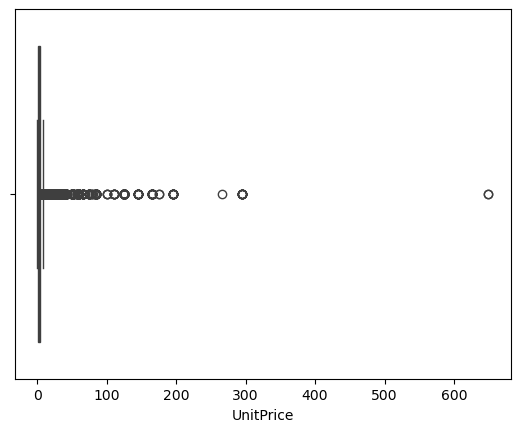

In [29]:
sns.boxplot(x=df0['UnitPrice'])

In [30]:
df0[df0['UnitPrice']>100].sort_values(by='UnitPrice', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,code_len
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom,False,5
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom,False,5
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406.0,United Kingdom,False,5
205759,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.0,13015.0,United Kingdom,False,5
133994,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-25 14:19:00,295.0,13452.0,United Kingdom,False,5
...,...,...,...,...,...,...,...,...,...,...
338448,566557,22823,CHEST NATURAL WOOD 20 DRAWERS,2,2011-09-13 11:47:00,110.0,14646.0,Netherlands,False,5
61549,541426,22823,CHEST NATURAL WOOD 20 DRAWERS,4,2011-01-18 08:44:00,110.0,18233.0,United Kingdom,False,5
172793,551559,22823,CHEST NATURAL WOOD 20 DRAWERS,2,2011-05-03 10:42:00,110.0,16133.0,United Kingdom,False,5
468546,576512,22823,CHEST NATURAL WOOD 20 DRAWERS,4,2011-11-15 12:09:00,110.0,15524.0,United Kingdom,False,5


#### 2.4.2 Quantity
Quantity also shows extreme right skewness, with unusually large order sizes. To avoid excluding potentially high-value B2B customers, quantity outliers are retained.

<Axes: xlabel='Quantity'>

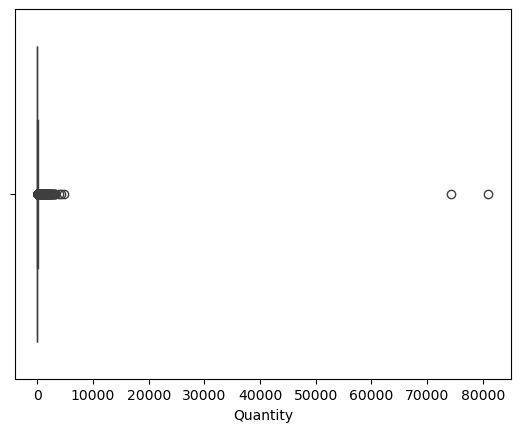

In [31]:
sns.boxplot(x=df0[df0['Quantity']>0]['Quantity'])

In [32]:
df0[df0['Quantity']>10000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,code_len
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,False,5
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,False,5


<Axes: xlabel='Quantity'>

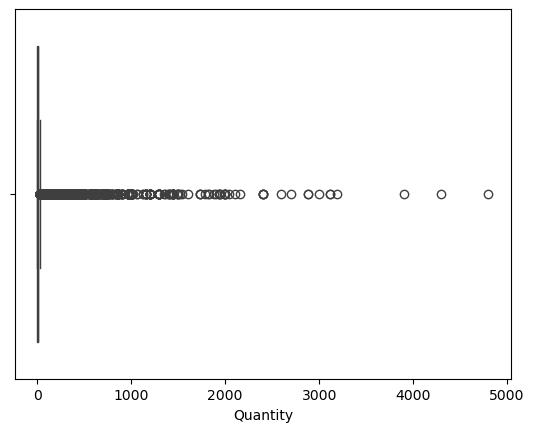

In [33]:
sns.boxplot(x=df0[(df0['Quantity']>0) & (df0['Quantity']<10000)]['Quantity'])

## 3. Exploratory Data Analysis
This section examines product popularity, geographic distribution, temporal patterns, sales concentration and cancellation insight, and validates assumptions for subsequent RFM analysis and clustering.

In [34]:
df0['Value'] = df0['Quantity'] * df0['UnitPrice']
df0['Month'] = df0['InvoiceDate'].dt.to_period('M')

df0_nc = df0[df0['Cancelled']==False]

Text(0.5, 1.0, 'Top 10 Best-Sellers by Quantity')

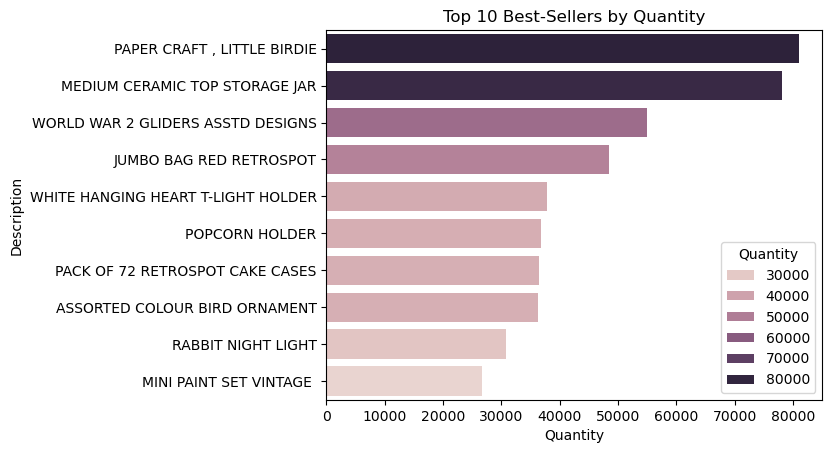

In [35]:
top_selling = df0_nc.groupby('Description')['Quantity'].sum().sort_values(ascending=False)[:10].reset_index()
sns.barplot(data=top_selling, x='Quantity', y='Description', hue='Quantity')
plt.title('Top 10 Best-Sellers by Quantity')

This chart highlights the top 10 best-selling products ranked by total quantity sold. The results show a strong dominance of small, decorative items such as paper crafts, storage jars, novelty bags, and home décor accessories.

In [36]:
country = df0_nc.groupby('Country')['Value'].sum().sort_values(ascending=False).reset_index()
fig = px.pie(country[:5], names='Country', values='Value', title='Total Sales by Country (Top 5)')

fig.show()

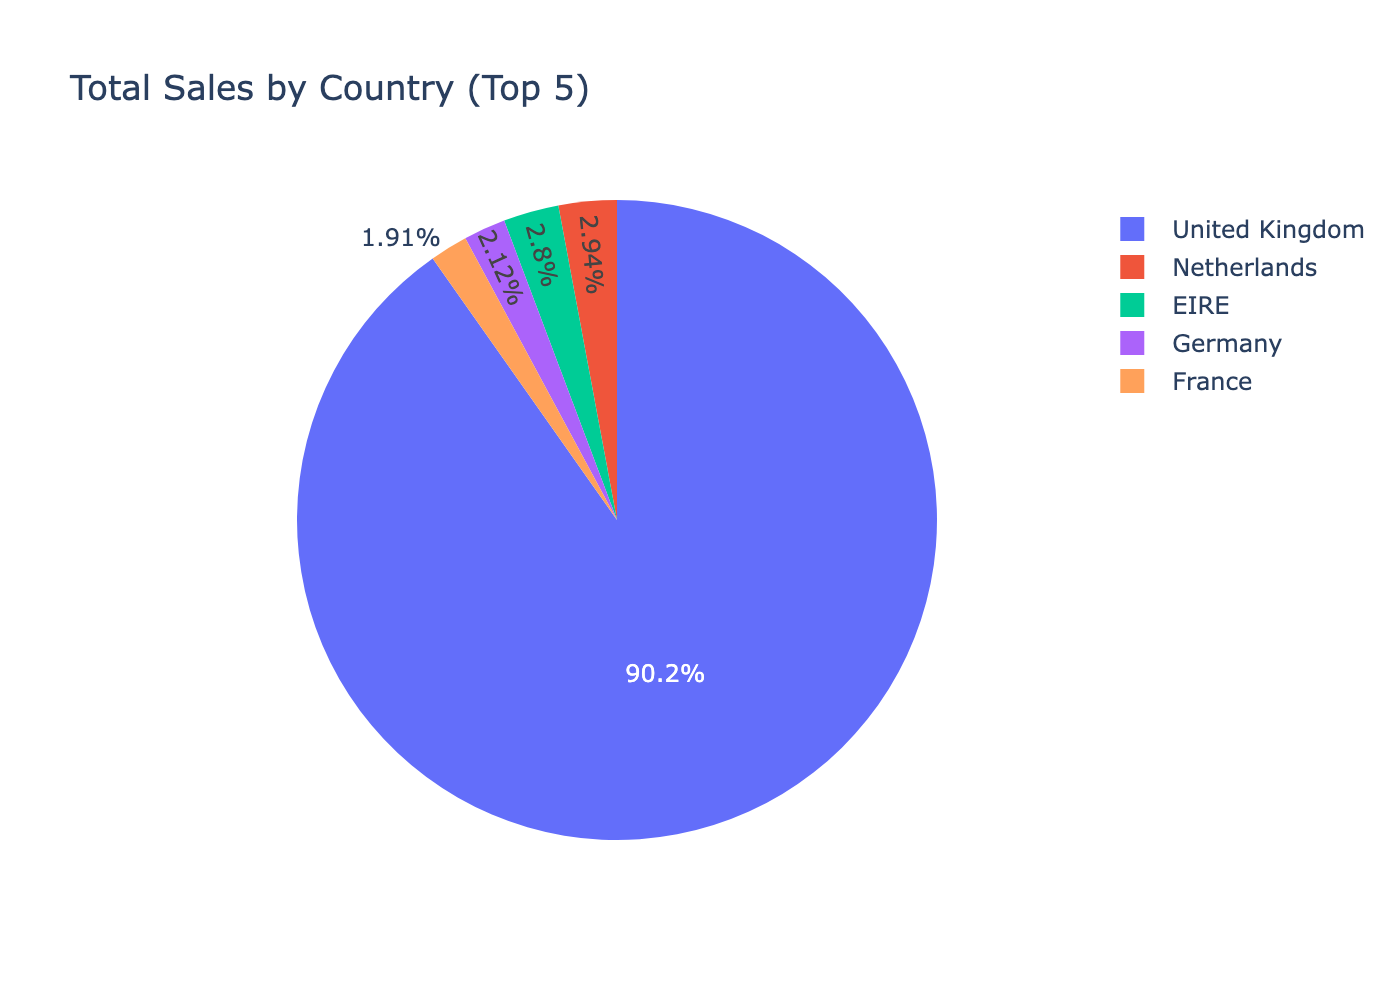

In [37]:
Image("total_sales_by_country.png")

UK dominates the dataset, accounting for 90.2% of total sales, reflecting the company’s domestic market focus.

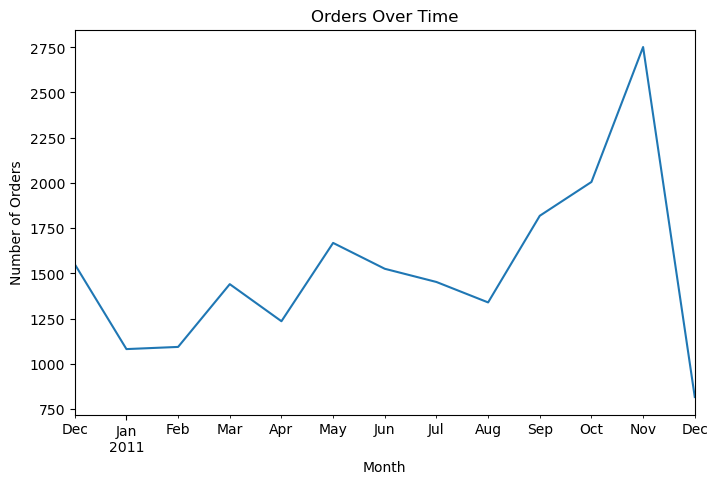

In [38]:
order_by_month = df0_nc.groupby(['Month'])['InvoiceNo'].nunique()

plt.figure(figsize=(8,5))
order_by_month.plot()
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Orders Over Time')
plt.show()

The graph shows that order number peaks at November and declines sharply in December. Since the dataset only includes transactions up to December 9, 2011, the sharp drop in December is probably due to incomplete data rather than an actual decline in demand.

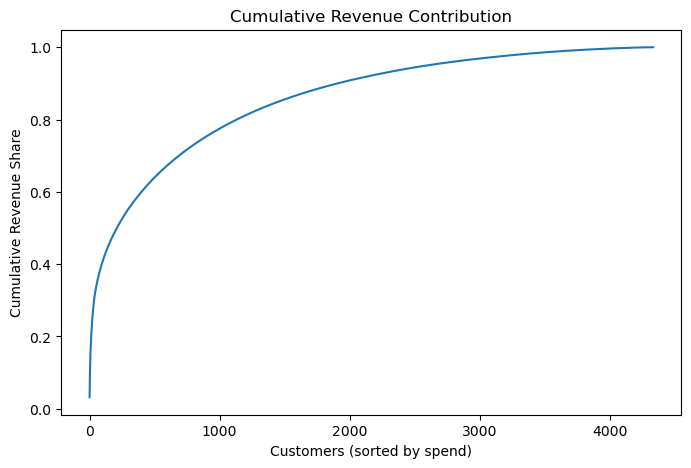

In [39]:
customer_sales = df0_nc.groupby('CustomerID')['Value'].sum().sort_values(ascending=False)
cum_sales = customer_sales.cumsum() / customer_sales.sum()

plt.figure(figsize=(8,5))
plt.plot(cum_sales.values)
plt.xlabel('Customers (sorted by spend)')
plt.ylabel('Cumulative Revenue Share')
plt.title('Cumulative Revenue Contribution')
plt.show()

The cumulative revenue contribution curve shows that a relatively small number of high-spending customers accounts for a large share of overall sales, while the majority of customers contribute marginally. This reinforces the importance of customer segmentation and targeted retention strategies.

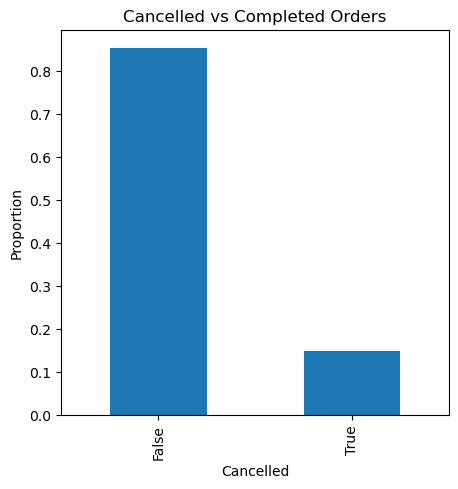

In [40]:
cancel = df0.drop_duplicates(subset=['InvoiceNo'], keep='first')
cancel_rate = cancel['Cancelled'].value_counts(normalize=True)

plt.figure(figsize=(5,5))
cancel_rate.plot(kind='bar')
plt.ylabel('Proportion')
plt.title('Cancelled vs Completed Orders')
plt.show()

Cancelled orders account for only a small proportion of total transactions.

The exploratory analysis reveals a highly concentrated customer base, strong seasonality in purchasing behavior, and a dominant domestic (UK) market. A small subset contributes disproportionately to total revenue, motivating the use of customer segmentation techniques in subsequent analysis.

## 4. RFM Segmentation

This section applies classical RFM analysis to summarize customer purchasing behavior in terms of recency, frequency, and monetary value. Transactions with missing CustomerID and cancellations are excluded to reduce noise and ensure interpretability.

RFM scores are discretized into quartiles and combined using rule-based logic to generate interpretable customer segments, enabling comparison across different behavioral profiles.


- __Recency__: Latest date-Last invoice date. (Number of days since the last purchase date)
- __Frequency__: Count of invoice numbers. (Total number of transactions made by a unique customer)
- __Monetary__: Sum of Total sales. (Total value of transacted sales by each customer)

In [41]:
df1 = df0[(df0['Cancelled'] == False) & (df0['CustomerID'] != 'nan')]

# monetary
monetary = df1.groupby('CustomerID')['Value'].sum().reset_index().rename(columns={'Value': 'Monetary'})

# frequency
frequency = df1.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'Frequency'})

# recency
reference_date = df0['InvoiceDate'].max() + pd.Timedelta(days=1)
recency = df1.groupby('CustomerID')['InvoiceDate'].max().reset_index().rename(columns={'InvoiceDate': 'Recency'})
recency['Recency'] = (reference_date - recency['Recency']).dt.days

# merge RFM
RFM = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')
RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,310,1,294.40


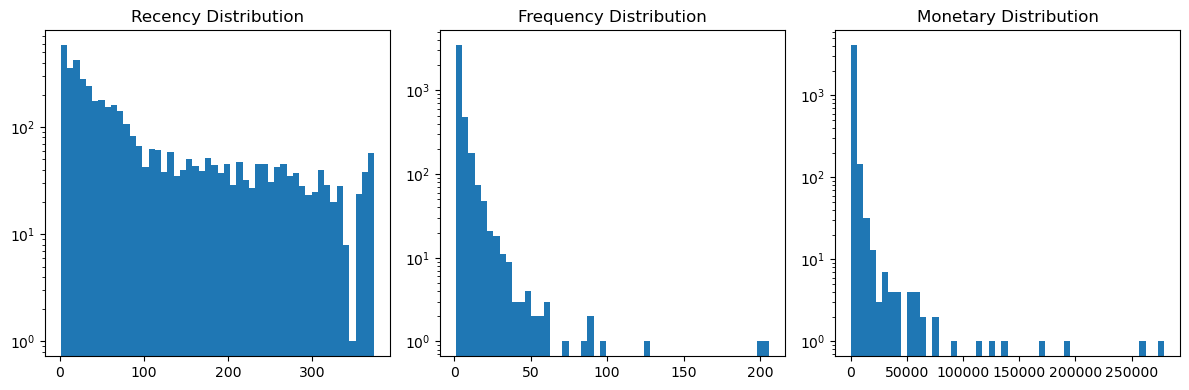

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(RFM['Recency'], bins=50, log=True)
plt.title('Recency Distribution')

plt.subplot(1,3,2)
plt.hist(RFM['Frequency'], bins=50, log=True)
plt.title('Frequency Distribution')

plt.subplot(1,3,3)
plt.hist(RFM['Monetary'], bins=50, log=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

In [43]:
R = RFM['Recency'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).reset_index()
F = RFM['Frequency'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).reset_index()
M = RFM['Monetary'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).reset_index()
Percentile = R.merge(F).merge(M)
Percentile

,index,Recency,Frequency,Monetary
0,count,4334.000000,4334.000000,4334.000000
1,mean,92.703046,4.245962,2015.973153
2,std,100.177047,7.634989,8903.673825
3,min,1.000000,1.000000,3.750000
4,25%,18.000000,1.000000,304.240000
5,50%,51.000000,2.000000,662.565000
6,75%,143.000000,5.000000,1631.622500
7,90%,263.000000,9.000000,3560.080000
8,95%,312.000000,13.000000,5735.215500
9,99%,369.000000,30.000000,18715.313000


In [44]:
RFM['R'] = pd.qcut(RFM['Recency'], 4, labels=[4,3,2,1])

RFM['F'] = pd.cut(RFM['Frequency'], 
                  bins=[0,1,2,5,float('inf')], 
                  labels=[1,2,3,4],
                  right = True
                 )

RFM['M'] = pd.qcut(RFM['Monetary'], 4, labels=[1,2,3,4])

RFM['Group'] = RFM['R'].astype(str) + RFM['F'].astype(str) + RFM['M'].astype(str)

In [45]:
def segment(row):
    R, F, M = row['R'], row['F'], row['M']
    
    if R >= 3 and F >= 3 and M >= 3:
        return 'Champions'
    elif R <= 2 and F >= 3 and M >= 3:
        return 'High-value churn risks'
    elif R >= 3 and F <= 2 and M <= 2:
        return 'New and promising'
    elif F >= 3 and M <= 2:
        return 'Frequent low spenders'
    elif F <= 2 and M >= 3:
        return 'Low frequency big spenders'
    elif R == 1 and F == 1 and M == 1:
        return 'Low-value customers'
    else:
        return 'Others'

In [46]:
RFM['Segment'] = RFM.apply(segment, axis=1)
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Segment
0,12346.0,326,1,77183.60,1,1,4,114,Low frequency big spenders
1,12347.0,2,7,4310.00,4,4,4,444,Champions
2,12348.0,75,4,1437.24,2,3,3,233,High-value churn risks
3,12349.0,19,1,1457.55,3,1,3,313,Low frequency big spenders
4,12350.0,310,1,294.40,1,1,1,111,Low-value customers


In [47]:
seg_counts = RFM['Segment'].value_counts().reset_index()

fig = px.pie(seg_counts, names='Segment', values='count', title='Customer Segments')
fig.show()

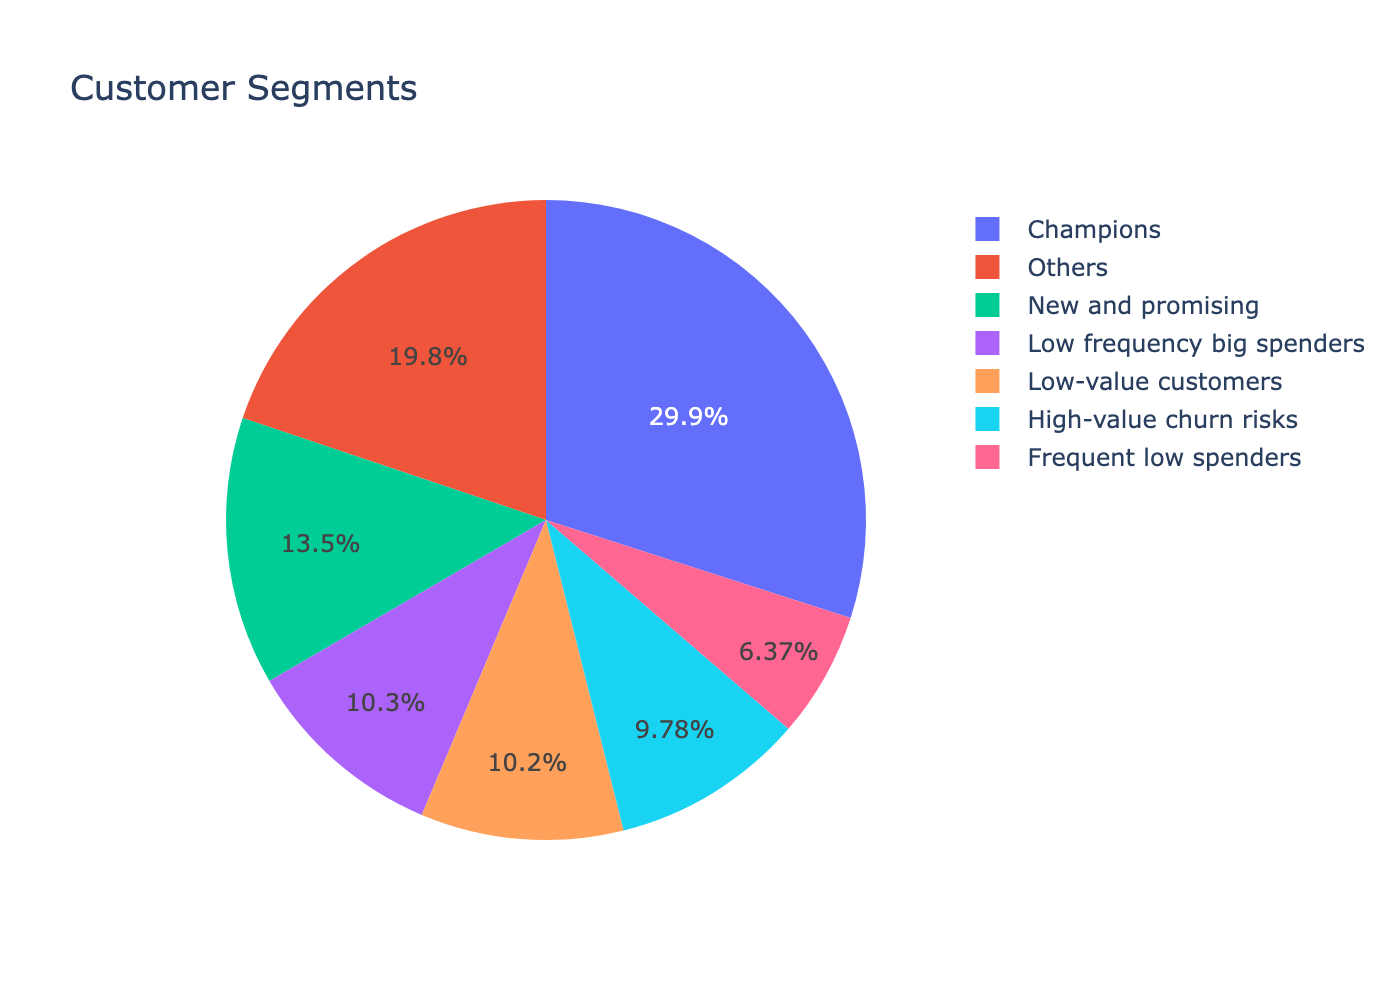

In [48]:
Image("customer_segments.png")

In [49]:
seg_counts.head(10)

,Segment,count
0,Champions,1298
1,Others,860
2,New and promising,587
3,Low frequency big spenders,445
4,Low-value customers,444
5,High-value churn risks,424
6,Frequent low spenders,276


In [50]:
seg_value = RFM.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].sum().reset_index()
fig = px.pie(seg_value, names='Segment', values='Monetary', title='Monetary value by segment')
fig.show()

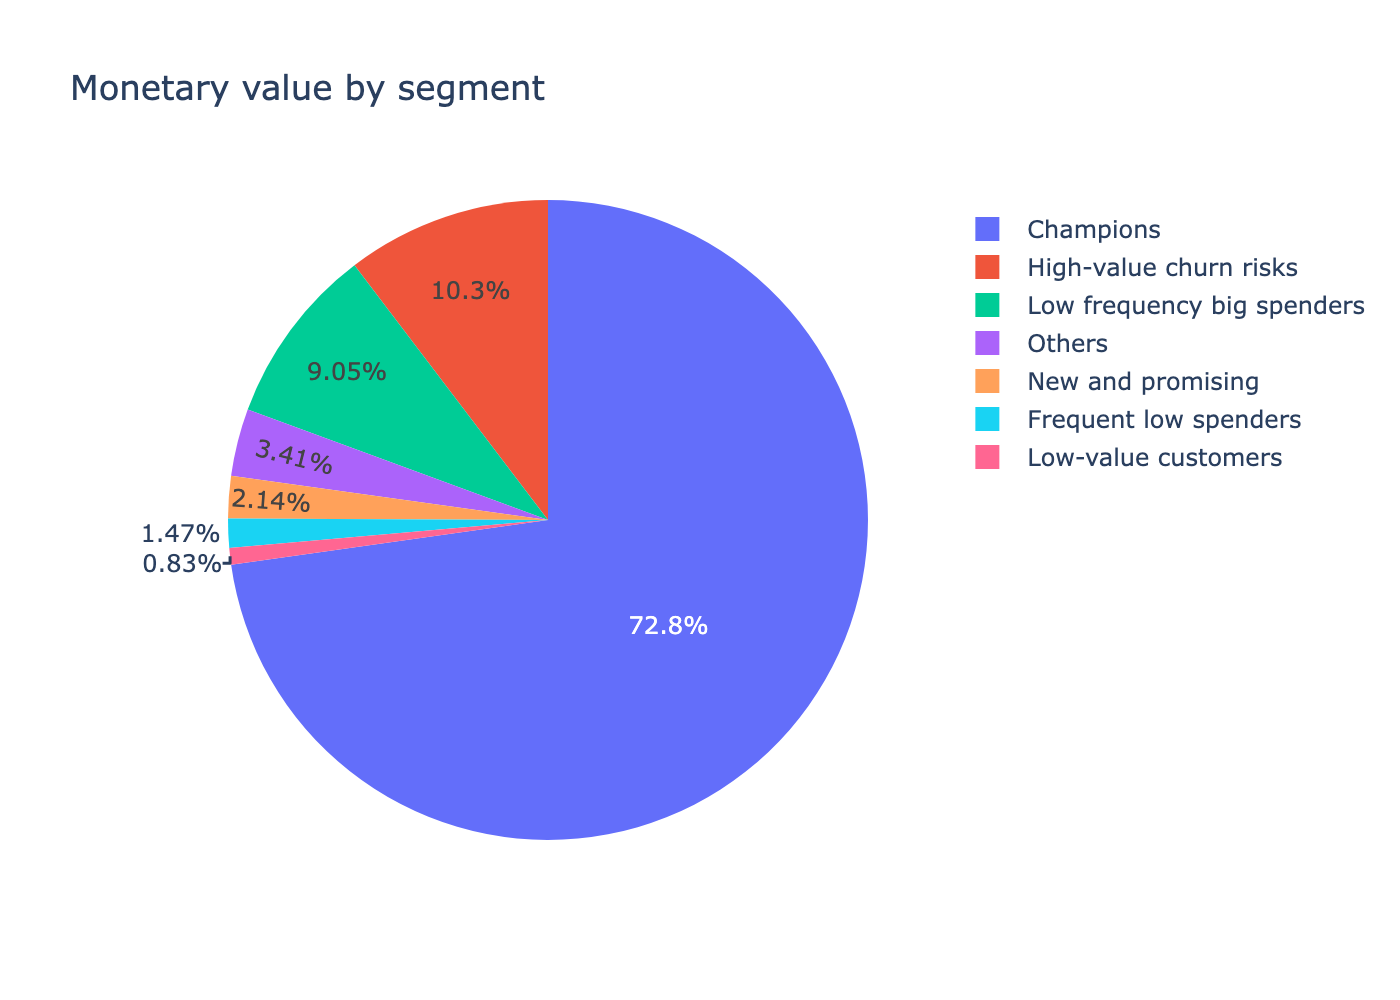

In [51]:
Image("monetary_by_segment.png")

In [52]:
seg_value

,Segment,Recency,Frequency,Monetary
0,Champions,22021,12239,6358314.671
1,Frequent low spenders,21251,955,128210.910
2,High-value churn risks,44498,2041,903205.580
3,Low frequency big spenders,46823,744,790533.551
4,Low-value customers,119018,444,72519.330
5,New and promising,14672,827,186597.370
6,Others,133492,1152,297846.231


**Key Insights from RFM Segmentation:**

- **Champions** are a relatively small group (29.9%) of high-value customers who contribute the largest share of total revenue (72.8%).
- **High-value churn risk customers** generate substantial monetary value (9 million) but exhibit low recency scores, indicating strong spending potential combined with disengagement risk.
- **Low frequency big spenders** also generate high monetary value (7.8 million), highlighting opportunities for targeted promotions or early retention strategies.
- **New and promising customers** show strong recent engagement but have not yet reached their full value, indicating potential for growth through targeted nurturing.
  
Overall, customer behavior is highly heterogeneous, with clear differences in purchasing frequency, spending intensity, and recency, reinforcing the importance of targeted retention strategies. 

While RFM provides valuable insights, rule-based segmentation alone may oversimplify customer behavior. K-means clustering might help capture more nuanced customer behavior patterns.

## 5. K-Means Clustering
K-means clustering is used here to uncover more nuanced customer behavior patterns in a more data-driven manner. Additional behavioral features are engineered to capture customer engagement, stability, and purchasing intensity.

### 5.1 Feature Engineering
Customer-level features are constructed by aggregating transaction data to capture order value characteristics, product diversity, purchasing regularity, and cancellation behavior. These features aim to complement RFM metrics with richer behavioral signals.

#### 5.11 Create New Features
- Average Order Value
- Days Active
- Cancellation Rate
- Is UK

In [53]:
customer = RFM.copy()
customer = customer.drop(['R','F','M','Group','Segment'], axis=1)

In [54]:
# Average Order Value
customer['Average_Order_Value'] = customer['Monetary'] / customer['Frequency']

In [55]:
# Days Active
active_days = df1.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max']).reset_index()
active_days['Active_Days'] = (active_days['max'] - active_days['min']).dt.days
customer = customer.merge(active_days[['CustomerID', 'Active_Days']], on='CustomerID')

In [56]:
# Cancellation Rate
df2 = df0[df0['CustomerID'] != 'nan']
orders = df2.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo':'TotalOrders'})
cancelled_orders = df2[df2['Cancelled']==True].groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo':'CancelledOrders'})
Cancellation_Rate = orders.merge(cancelled_orders, on='CustomerID', how='left').fillna(0)
Cancellation_Rate['Cancellation_Rate'] = Cancellation_Rate['CancelledOrders']/Cancellation_Rate['TotalOrders']
customer = customer.merge(Cancellation_Rate[['CustomerID', 'Cancellation_Rate']], on='CustomerID', how='left')

In [57]:
# Is UK
# 先检查是否每个customer对应一个country
country = df1.groupby('CustomerID')['Country'].nunique().reset_index()
country['Country'].value_counts()

Country
1    4326
2       8
Name: count, dtype: int64

In [58]:
# 仅保留交易次数最多的country
cust_country = df1.drop_duplicates(['InvoiceNo']).groupby(['CustomerID', 'Country']).size().reset_index(name='order_count')
primary_country = cust_country.sort_values(['CustomerID', 'order_count'], ascending=[True, False]).drop_duplicates('CustomerID')

# Create dummy
primary_country['Is_UK'] = primary_country['Country'] == 'United Kingdom'
primary_country['Is_UK'] = primary_country['Is_UK'].astype(int)
customer = customer.merge(primary_country[['CustomerID', 'Is_UK']], on='CustomerID')

In [59]:
customer.head()

,CustomerID,Recency,Frequency,Monetary,Average_Order_Value,Active_Days,Cancellation_Rate,Is_UK
0,12346.0,326,1,77183.60,77183.600000,0,0.5,1
1,12347.0,2,7,4310.00,615.714286,365,0.0,0
2,12348.0,75,4,1437.24,359.310000,282,0.0,0
3,12349.0,19,1,1457.55,1457.550000,0,0.0,0
4,12350.0,310,1,294.40,294.400000,0,0.0,0


#### 5.12 Feature Scaling
Due to heavy right-skewness in monetary and frequency-related variables, log transformation is applied before standardization.

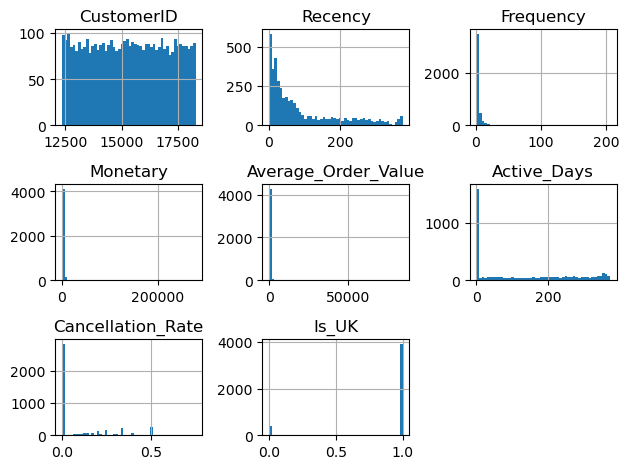

In [60]:
customer.hist(bins=50)
plt.tight_layout()

In [61]:
# 给所有skewed features做log
customer1 = customer.copy()

columns = ['Recency', 'Frequency', 'Monetary', 'Active_Days', 'Average_Order_Value']
for col in columns:
    customer1['log_'+col] = np.log1p(customer1[col])

In [62]:
features = ['log_Recency','log_Frequency','log_Monetary',
            'log_Active_Days','log_Average_Order_Value',
            'Is_UK','Cancellation_Rate']

X = customer1[features]
X_scaled = StandardScaler().fit_transform(X)

### 5.2 Data Modeling
K-means clustering is applied to the standardized feature set. The number of clusters is determined through a combination of inertia-based and silhouette-based evaluation.

#### 5.21 Finding Optimal K-Value
The elbow method does not provide a clear elbow, while silhouette scores peak at k = 3. Therefore, a three-cluster solution is selected.

In [63]:
# Elbow method

num_clusters = [i for i in range(2, 11)]

def kmeans_inertia(num_clusters, x_vals):
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
    return inertia

inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

[20865.923989282295,
 17282.672536895407,
 14750.869918082724,
 12575.08500163077,
 11695.523635263908,
 10851.128184795149,
 9803.656122443892,
 8983.066001649562,
 8361.902915840596]

Text(0, 0.5, 'Inertia')

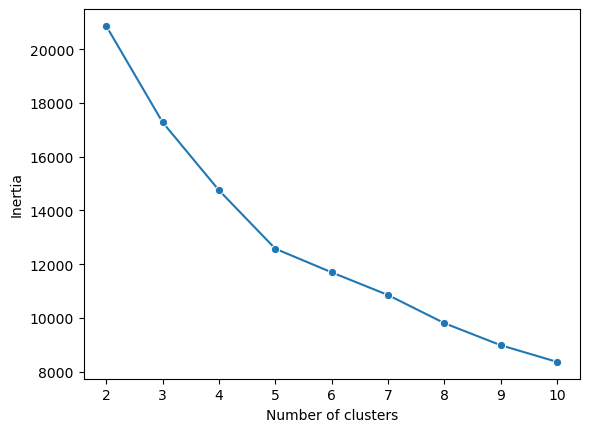

In [64]:
# Elbow plot
plot = sns.lineplot(x=num_clusters, y=inertia, marker='o')
plot.set_xlabel('Number of clusters')
plot.set_ylabel('Inertia')

In [65]:
# silhouette method

def kmeans_sil(num_clusters, x_vals):
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))
    return sil_score

sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

[0.2987364807569959,
 0.32655150717299347,
 0.26379643016142346,
 0.29736836473166217,
 0.2648069988429221,
 0.26835633340358955,
 0.25723590669322344,
 0.26658917897897183,
 0.2644461626502341]

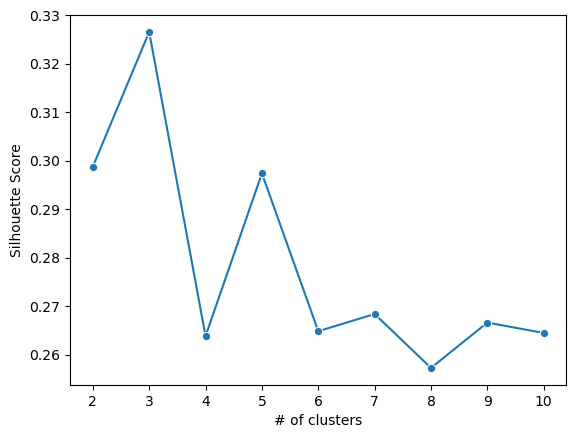

In [66]:
# silhouette plot

plot = sns.lineplot(x=num_clusters, y=sil_score, marker='o')
plot.set_xlabel('# of clusters')
plot.set_ylabel('Silhouette Score');

#### 5.22 Fit a 3-Cluster Model
A K-means model with three clusters is fitted to the data.

In [67]:
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans3.fit(X_scaled)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [68]:
print(kmeans3.labels_[:3])
print('Unique labels:', np.unique(kmeans3.labels_))

[0 2 2]
Unique labels: [0 1 2]


In [69]:
customer1['cluster'] = kmeans3.labels_
customer1.head()

,CustomerID,Recency,Frequency,Monetary,Average_Order_Value,Active_Days,Cancellation_Rate,Is_UK,log_Recency,log_Frequency,log_Monetary,log_Active_Days,log_Average_Order_Value,cluster
0,12346.0,326,1,77183.60,77183.600000,0,0.5,1,5.789960,0.693147,11.253955,0.000000,11.253955,0
1,12347.0,2,7,4310.00,615.714286,365,0.0,0,1.098612,2.079442,8.368925,5.902633,6.424406,2
2,12348.0,75,4,1437.24,359.310000,282,0.0,0,4.330733,1.609438,7.271175,5.645447,5.886965,2
3,12349.0,19,1,1457.55,1457.550000,0,0.0,0,2.995732,0.693147,7.285198,0.000000,7.285198,2
4,12350.0,310,1,294.40,294.400000,0,0.0,0,5.739793,0.693147,5.688330,0.000000,5.688330,2


### 5.3 Model Evaluation
Cluster-level statistics reveal clear behavioral differences across segments in terms of recency, purchase frequency, spending level, and engagement duration. Although the clusters are moderately imbalanced, each group exhibits distinct and interpretable characteristics.

In [70]:
customer1['cluster'].value_counts(normalize=True)

cluster
0    0.484541
1    0.419243
2    0.096216
Name: proportion, dtype: float64

In [71]:
features = ['Recency', 'Frequency', 'Monetary', 'Active_Days', 'Average_Order_Value', 'Is_UK', 'Cancellation_Rate']
profile = customer1.groupby('cluster')[features].mean()
profile

,Recency,Frequency,Monetary,Active_Days,Average_Order_Value,Is_UK,Cancellation_Rate
cluster,,,,,,,
0,41.589524,6.838095,3221.559763,225.403333,487.492853,0.999524,0.133326
1,150.981288,1.330215,337.777463,21.768850,280.744259,1.000000,0.060865
2,96.172662,3.896882,3257.099496,124.124700,639.941064,0.000000,0.114827


In [72]:
# Radar Chart
scaler = MinMaxScaler()
profile_scaled = pd.DataFrame(
    scaler.fit_transform(profile),
    index=profile.index,
    columns=profile.columns
)

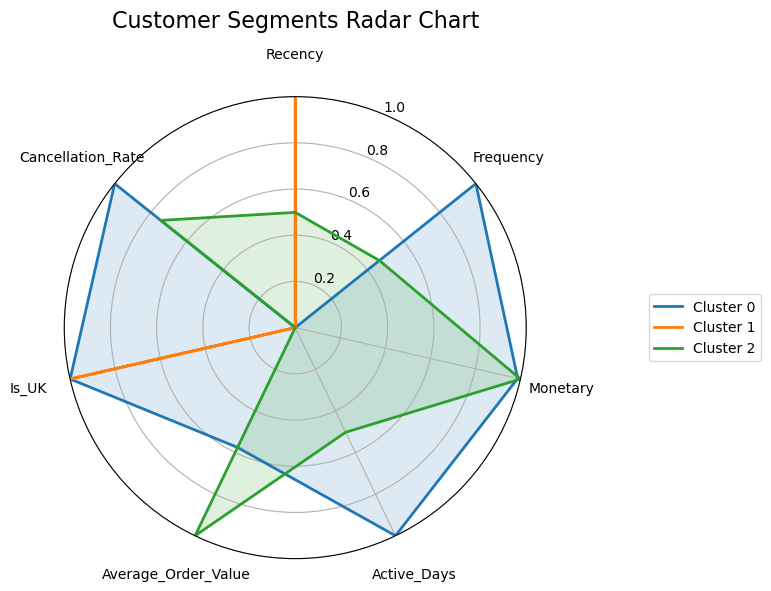

In [73]:
labels = features
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for cluster in profile_scaled.index:
    values = profile_scaled.loc[cluster].tolist()
    values += values[:1]
    
    ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.15)


ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.tick_params(pad=20)

ax.set_ylim(0, 1)
ax.set_title('Customer Segments Radar Chart', size=16, pad=50)

ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
plt.show();

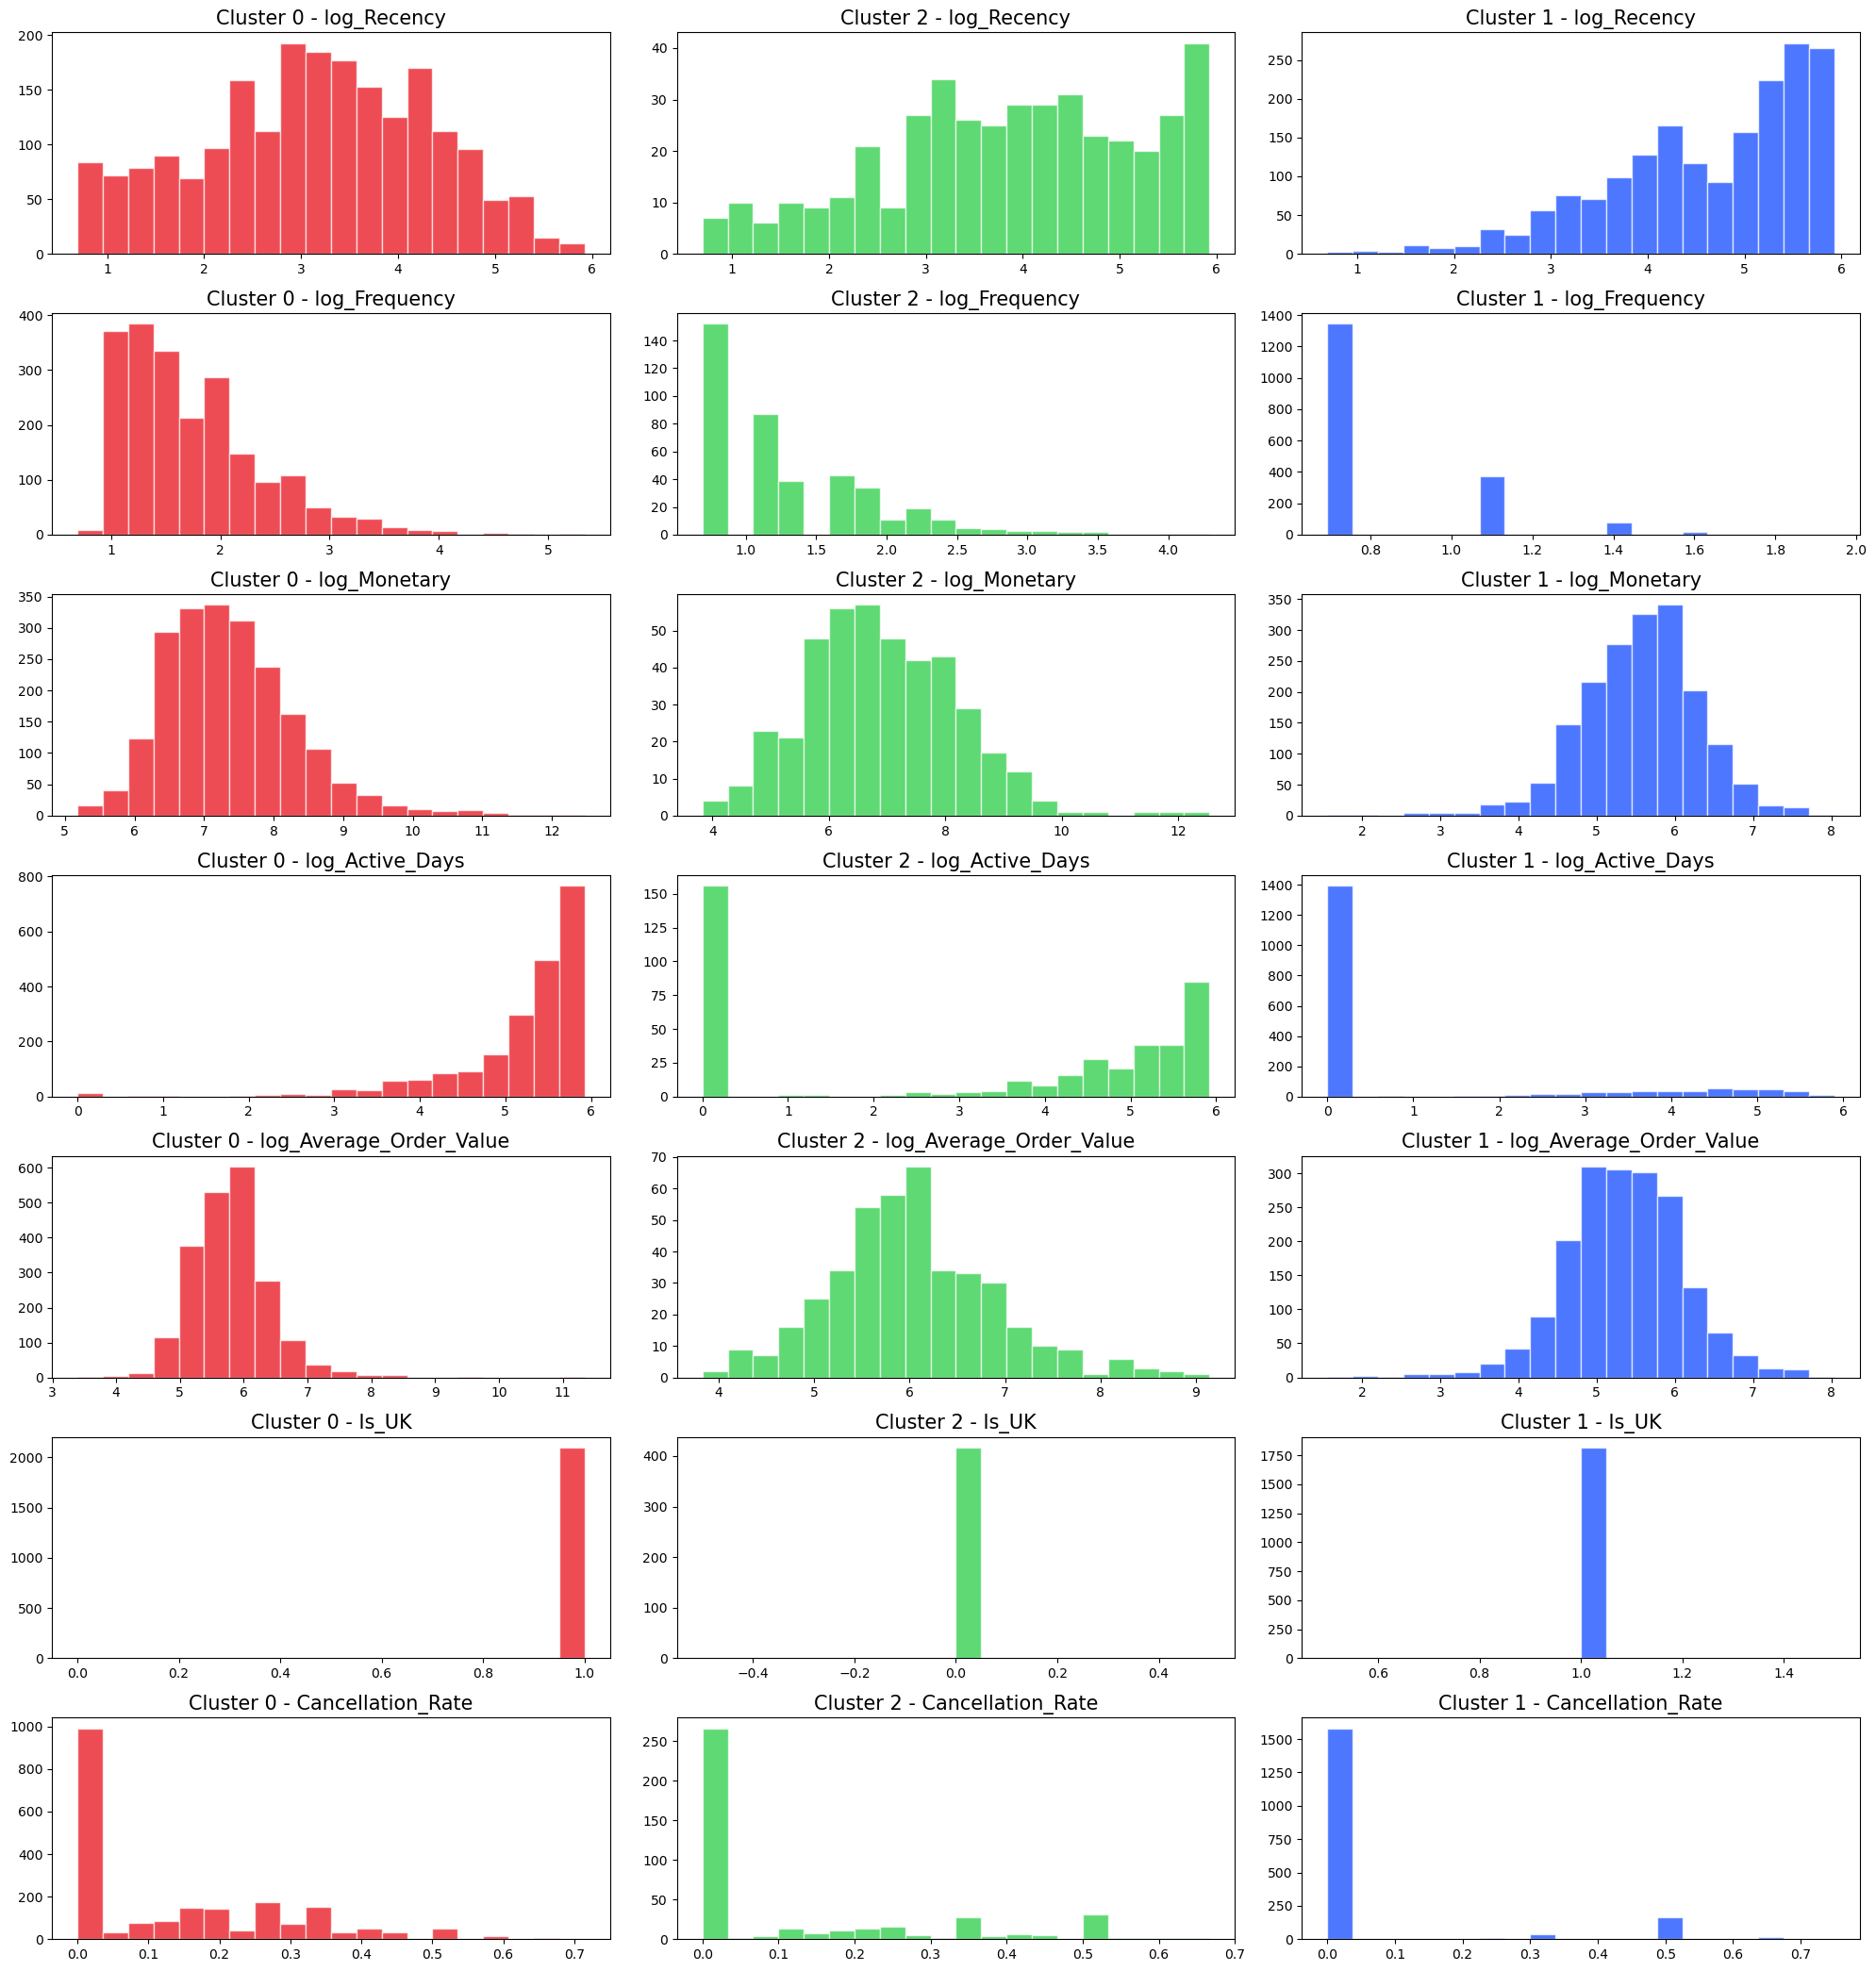

In [74]:
features = ['log_Recency','log_Frequency','log_Monetary',
            'log_Active_Days','log_Average_Order_Value',
            'Is_UK','Cancellation_Rate']
clusters = customer1['cluster'].unique()

n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

colors = ['#e8000b', '#1ac938', '#023eff']

for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer1[customer1['cluster']==cluster][feature]
        axes[i, j].hist(data, bins=20, color = colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')
        
plt.tight_layout()
plt.show()

**The three-cluster solution reveals clear and interpretable differences in customer behavior across key dimensions.**

- **Cluster 0: Core Loyal Customers (48.5%)**
    - Cluster 0 represents highly engaged loyal customers with relatively low recency (41.6 days), high purchase frequency (6.84), long activity spans (225 days), and high monetary value (3,221). The majority of this cluster is from UK (99.95%). However, this group also shows the highest cancellation rate (13.3%), suggesting active but occasionally unstable purchasing behavior.
- **Cluster 1: Low-Engagement / Dormant UK Customers (41.9%)**
    - Cluster 1 consists of low-engagement UK customers characterized by high recency (151 days), low frequency (1.33), low monetary value (338), and very short active periods (22 days). Despite making up a large proportion of customers, this group contributes relatively little value and exhibits limited long-term engagement.
- **Cluster 2: High-Value Non-UK Customers (9.6%)**
    - Cluster 2 captures a smaller but distinct segment of high-spending customers with moderate frequency (3.90), high monetary value (3,257), longer activity spans (124 days), and the highest average order value (640). Notably, this cluster contains no UK customers, indicating potential geographic or market-specific behavior.

**Business Recommendations**
- For Core Loyal Customers (Cluster 0 / Champions), reward with loyalty programs, early product access or exclusive offers. Encourage repeat purchases with personalized recommendations and VIP treatment. Provide clearer order/return policies to reduce cancellation rate.
- For Low-Engagement UK Customers (Cluster 1), prioritize reactivation campaigns (e.g. offer exclusive discounts, send email reminders, tailor content and recommendations).
- For High-Value Non-UK Customers (Cluster 2), tailor cross-border strategies, such as localized promotions, shipping optimization and region-specific marketing campagins.

## Conclusion

This project combines classic RFM analysis with K-means clustering to provide a more complete and actionable understanding of customer behavior. RFM offers a clear, interpretable framework to assess customer value and lifecycle status, while K-means uncovers deeper behavioral patterns related to engagement duration, spending structure, geography, and cancellation risk.

Together, these approaches reveal that customer value is highly concentrated in a small number of segments, that a large portion of the customer base contributes limited long-term value, and that distinct high-value behaviors emerge outside the core domestic market. The results highlight the importance of moving beyond one-dimensional segmentation toward data-driven, differentiated strategies that balance retention, efficiency, and growth.